<a href="https://colab.research.google.com/github/yusufdalva/ML_implementations/blob/master/PyTorch_fundamentals/FashionMNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets, transforms

In [2]:
print("Using Pytorch {}".format(torch.__version__))

Using Pytorch 1.10.0+cu111


In [3]:
is_gpu_available = torch.cuda.is_available()
print("Is GPU being used: {}".format(is_gpu_available))
if is_gpu_available:
    print("There are {} GPU(s) available".format(torch.cuda.device_count()))
    device_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device_id)
    print("Name of the current GPU: {}".format(device_name))

Is GPU being used: True
There are 1 GPU(s) available
Name of the current GPU: Tesla T4


In [4]:
!nvidia-smi

Sun Apr  3 18:36:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # The images are grayscale, we only normalize one channel

train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform_data)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform_data)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=True) # Batch size is different just to show that it can be loaded differently

In [6]:
class FMNIST_Classifier(nn.Module):
    def __init__(self, conv_channels):
        super(FMNIST_Classifier, self).__init__()

        assert len(conv_channels) == 2 # I will have 2 consecutive convultional blocks
        self.conv_channels = conv_channels

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.conv_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(self.conv_channels[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_channels[0], out_channels=self.conv_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(self.conv_channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        output_size = (28 // 4) # Downsampled it 2 times
        self.fc_1 = nn.Linear(in_features=self.conv_channels[1] * output_size * output_size, out_features=128)
        self.fc_2 = nn.Linear(in_features=128, out_features=64)
        self.fc_3 = nn.Linear(in_features=64, out_features=10) # Predicting probabilities for 10 class

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(-1, self.conv_channels[1] * 7 * 7) # Flatten the tensor
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x


In [7]:
criterion = nn.CrossEntropyLoss()
conv_channels = [32, 64]
model = FMNIST_Classifier(conv_channels)
if is_gpu_available:
    model.cuda()

In [8]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
from tqdm import tqdm
# Training loop
no_of_epochs = 20
iter_losses = []
epoch_losses = []
for epoch in range(no_of_epochs):
    running_loss = 0.0
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        optimizer.zero_grad() # Setting the starting gradients as 0
        batch_outputs = model(batch_data.cuda()) # Predict outputs
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) # Calculate the loss
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        running_loss += loss.item()
    epoch_losses.append(running_loss / len(train_data_loader))
    print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))
print("Finished Training!")


Epoch: 1/20


100%|██████████| 469/469 [00:15<00:00, 30.88it/s]


Loss for epoch: 1.4815982406073287
Epoch: 2/20


100%|██████████| 469/469 [00:12<00:00, 37.43it/s]


Loss for epoch: 0.8183019900881151
Epoch: 3/20


100%|██████████| 469/469 [00:12<00:00, 36.82it/s]


Loss for epoch: 0.6616835556050608
Epoch: 4/20


100%|██████████| 469/469 [00:12<00:00, 37.48it/s]


Loss for epoch: 0.5911397022733302
Epoch: 5/20


100%|██████████| 469/469 [00:13<00:00, 34.74it/s]


Loss for epoch: 0.5460640310859883
Epoch: 6/20


100%|██████████| 469/469 [00:12<00:00, 36.50it/s]


Loss for epoch: 0.512151083775929
Epoch: 7/20


100%|██████████| 469/469 [00:12<00:00, 36.98it/s]


Loss for epoch: 0.48511596751619757
Epoch: 8/20


100%|██████████| 469/469 [00:12<00:00, 37.32it/s]


Loss for epoch: 0.4629186722896755
Epoch: 9/20


100%|██████████| 469/469 [00:12<00:00, 37.39it/s]


Loss for epoch: 0.44410249673481433
Epoch: 10/20


100%|██████████| 469/469 [00:12<00:00, 37.06it/s]


Loss for epoch: 0.4281279765593726
Epoch: 11/20


100%|██████████| 469/469 [00:12<00:00, 37.07it/s]


Loss for epoch: 0.4140495738622222
Epoch: 12/20


100%|██████████| 469/469 [00:12<00:00, 37.25it/s]


Loss for epoch: 0.4017450398028786
Epoch: 13/20


100%|██████████| 469/469 [00:12<00:00, 37.05it/s]


Loss for epoch: 0.3905448902136227
Epoch: 14/20


100%|██████████| 469/469 [00:12<00:00, 36.21it/s]


Loss for epoch: 0.3805307779929785
Epoch: 15/20


100%|██████████| 469/469 [00:12<00:00, 37.45it/s]


Loss for epoch: 0.37146605106432046
Epoch: 16/20


100%|██████████| 469/469 [00:12<00:00, 37.25it/s]


Loss for epoch: 0.36325885571523514
Epoch: 17/20


100%|██████████| 469/469 [00:12<00:00, 37.12it/s]


Loss for epoch: 0.3557420047297915
Epoch: 18/20


100%|██████████| 469/469 [00:12<00:00, 37.12it/s]


Loss for epoch: 0.3487204694862305
Epoch: 19/20


100%|██████████| 469/469 [00:12<00:00, 36.81it/s]


Loss for epoch: 0.34252228004845986
Epoch: 20/20


100%|██████████| 469/469 [00:12<00:00, 37.00it/s]

Loss for epoch: 0.33623334041028136
Finished Training!


In [15]:
model.eval()
correct_preds = 0
total_preds = 0
all_preds = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for batch_data, batch_labels in test_data_loader:
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()
        batch_outputs = model(batch_data)
        # Max returns: (max_values, max_indices)
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels).sum().item()
        all_preds = torch.cat((all_preds, pred_labels.cpu()), dim=0)
        all_labels = torch.cat((all_labels, batch_labels.cpu()), dim=0)
    print("Accuracy: {}".format(correct_preds / total_preds))

Accuracy: 0.8717


In [16]:
confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
for label_idx in range(len(all_labels)):
    predicted = all_preds[label_idx].int()
    real = all_labels[label_idx].int()
    confusion_matrix[real, predicted] += 1

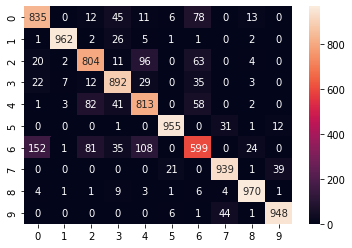

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix.numpy(), annot=True, fmt="d")
fig.show()

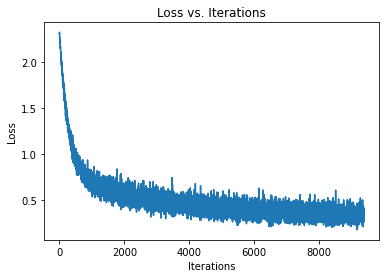

In [18]:
fig, ax = plt.subplots()
ax.plot(range(len(iter_losses)), iter_losses)
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Iterations")
fig.show()

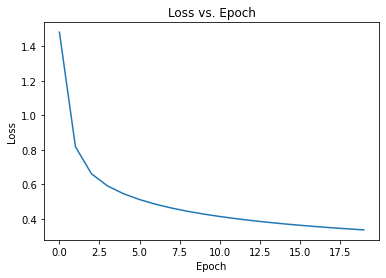

In [19]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_losses)), epoch_losses)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epoch")
fig.show()